# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Big Data Real-Time Analytics com Python e Spark</font>

## <font color='blue'>Mini-Projeto 3</font>

### <font color='blue'>Análise Transporte Público = Fev 2024</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.5


In [2]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [3]:
# Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import row_number
from pyspark.sql.functions import lead  
from pyspark.sql.functions import min, max
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import mean
import pyspark.sql.functions as F
from pyspark.sql.functions import month
import pandas as pd
from pyspark.sql.types import IntegerType
from sklearn import preprocessing
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

seaborn   : 0.12.2
sklearn   : 1.3.0
pyspark   : 3.4.1
findspark : 2.0.1
matplotlib: 3.7.2
pandas    : 2.0.3



## Preparando o Ambiente Spark

In [5]:
# Criando o Spark Context
sc = SparkContext(appName = "Mini-Projeto3-TransportPublic3" )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/12 20:18:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# Cria a sessão
spark = SparkSession.builder.getOrCreate()

In [7]:
spark

## Carregando os Dados Como Dataframe do Spark

In [8]:
# TFL Bus Safety.xlsx
# Nome do arquivo
arquivo = 'TFL Bus Safety.xlsx'

In [9]:
# Carrega como dataframe do Spark

df_pandas = pd.read_excel(arquivo)

# Convert Pandas dataframe to Spark dataframe
df_spark = spark.createDataFrame(df_pandas)




## Funções

In [10]:
# Function to unify texts
def unify_text(text):
    # Convert text to lowercase and remove whitespace
    text = text.lower().strip()
    # You can add more text processing steps here if needed
    return text


## Data Wrangling

In [11]:
df_pandas['Victim Category'] = df_pandas['Victim Category'].apply(unify_text)
df_spark = spark.createDataFrame(df_pandas)


In [12]:
# Verifica Count of Null, None, NaN of All DataFrame Columns
df_spark.dropna()


DataFrame[Year: bigint, Date Of Incident: timestamp, Route: string, Operator: string, Group Name: string, Bus Garage: string, Borough: string, Injury Result Description: string, Incident Event Type: string, Victim Category: string, Victims Sex: string, Victims Age: string]

In [13]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# Remove os espaços das colunas
df_spark = df_spark.withColumnRenamed("Date Of Incident","DateOfIncident") \
                   .withColumnRenamed("Bus Garage","BusGarage") \
                   .withColumnRenamed("Injury Result Description","InjuryResultDescription") \
                   .withColumnRenamed("Incident Event Type","IncidentEventType") \
                   .withColumnRenamed("Victim Category","VictimCategory") \
                   .withColumnRenamed("Victims Sex","VictimsSex") \
                   .withColumnRenamed("Victims Age","VictimsAge")                  
df_spark.printSchema()

df_spark = df_spark.withColumn ('MonthofIncident', month (df_spark ['DateOfIncident'])) 

df_pandas = df_spark.select('Year', 'Route', 'Operator', 'BusGarage',  'InjuryResultDescription', 'IncidentEventType', 'VictimCategory', 'VictimsAge', 'MonthofIncident').toPandas()



root
 |-- Year: long (nullable = true)
 |-- DateOfIncident: timestamp (nullable = true)
 |-- Route: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- BusGarage: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- InjuryResultDescription: string (nullable = true)
 |-- IncidentEventType: string (nullable = true)
 |-- VictimCategory: string (nullable = true)
 |-- VictimsSex: string (nullable = true)
 |-- VictimsAge: string (nullable = true)



In [15]:
# Para todos os valores "Unknown" foram removidos do Dataset, por não representar a categoria correta e não distorcer as análises 
df_spark = df_spark[(df_spark['VictimsAge'] != 'Unknown')]
df_spark = df_spark[(df_spark['VictimsSex'] != 'Unknown')]


## Análise Exploratória

In [16]:
df_spark.show(5)

+----+-------------------+-----+--------------+----------+--------------------+-------------------+-----------------------+-----------------+--------------+----------+----------+---------------+
|Year|     DateOfIncident|Route|      Operator|Group Name|           BusGarage|            Borough|InjuryResultDescription|IncidentEventType|VictimCategory|VictimsSex|VictimsAge|MonthofIncident|
+----+-------------------+-----+--------------+----------+--------------------+-------------------+-----------------------+-----------------+--------------+----------+----------+---------------+
|2015|2015-01-01 00:00:00|    1|London General|  Go-Ahead|Garage Not Available|          Southwark|   Injuries treated ...| Onboard Injuries|     passenger|      Male|     Child|              1|
|2015|2015-01-01 00:00:00|    5|   East London|Stagecoach|Garage Not Available|           Havering|   Taken to Hospital...| Onboard Injuries|     passenger|      Male|   Elderly|              1|
|2015|2015-01-01 00:00:00

In [17]:
# Número de registros
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_pandas=df_spark.toPandas()
print(df_pandas.shape)

24/02/12 20:18:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


(15312, 13)


## Criando Tabela Temporária

Criamos uma tabela temporária para executar consultas SQL nos dados. A tabela temporária existe somente nesta sessão.

In [18]:
# Cria tabela temporária
df_spark.createOrReplaceTempView("tb_transpopublico")

In [19]:
# Verificando as colunas da tabela
spark.sql("SHOW COLUMNS FROM tb_transpopublico").show()

+--------------------+
|            col_name|
+--------------------+
|                Year|
|      DateOfIncident|
|               Route|
|            Operator|
|          Group Name|
|           BusGarage|
|             Borough|
|InjuryResultDescr...|
|   IncidentEventType|
|      VictimCategory|
|          VictimsSex|
|          VictimsAge|
|     MonthofIncident|
+--------------------+



In [20]:
# Visualizando os 5 primeiros registros
spark.sql("SELECT * FROM tb_transpopublico LIMIT 5").show()

+----+-------------------+-----+--------------+----------+--------------------+-------------------+-----------------------+-----------------+--------------+----------+----------+---------------+
|Year|     DateOfIncident|Route|      Operator|Group Name|           BusGarage|            Borough|InjuryResultDescription|IncidentEventType|VictimCategory|VictimsSex|VictimsAge|MonthofIncident|
+----+-------------------+-----+--------------+----------+--------------------+-------------------+-----------------------+-----------------+--------------+----------+----------+---------------+
|2015|2015-01-01 00:00:00|    1|London General|  Go-Ahead|Garage Not Available|          Southwark|   Injuries treated ...| Onboard Injuries|     passenger|      Male|     Child|              1|
|2015|2015-01-01 00:00:00|    5|   East London|Stagecoach|Garage Not Available|           Havering|   Taken to Hospital...| Onboard Injuries|     passenger|      Male|   Elderly|              1|
|2015|2015-01-01 00:00:00

In [21]:
# Describe da tabela
spark.sql("DESCRIBE tb_transpopublico").show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                Year|   bigint|   null|
|      DateOfIncident|timestamp|   null|
|               Route|   string|   null|
|            Operator|   string|   null|
|          Group Name|   string|   null|
|           BusGarage|   string|   null|
|             Borough|   string|   null|
|InjuryResultDescr...|   string|   null|
|   IncidentEventType|   string|   null|
|      VictimCategory|   string|   null|
|          VictimsSex|   string|   null|
|          VictimsAge|   string|   null|
|     MonthofIncident|      int|   null|
+--------------------+---------+-------+



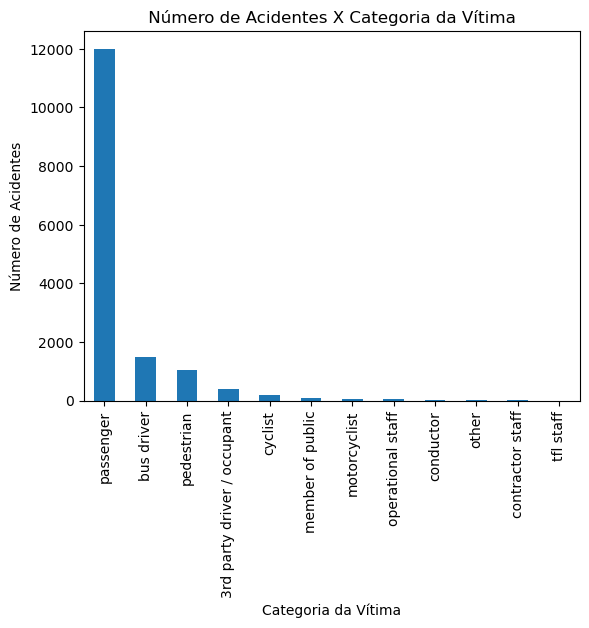

In [22]:


# Calculate count per category VictimCategory
df_pandas['VictimCategory'].value_counts().plot(kind='bar')
plt.xlabel('Categoria da Vítima')            
plt.ylabel('Número de Acidentes')
plt.title(' Número de Acidentes X Categoria da Vítima ') 
plt.show()

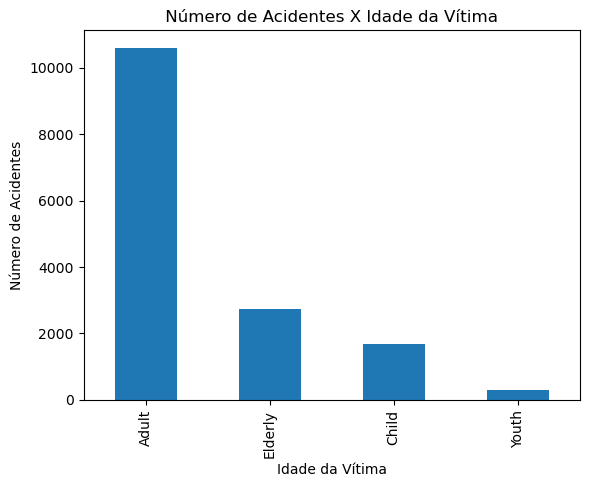

In [23]:

# Calculate count per category VictimAge
df_pandas['VictimsAge'].value_counts().plot(kind='bar')
plt.xlabel('Idade da Vítima')            
plt.ylabel('Número de Acidentes')
plt.title(' Número de Acidentes X Idade da Vítima ') 
plt.show()

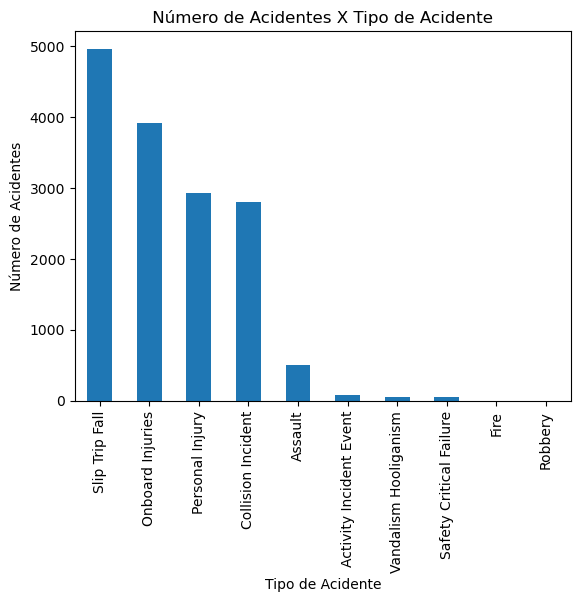

In [24]:

# Calculate count per category VictimAge
df_pandas['IncidentEventType'].value_counts().plot(kind='bar')
plt.xlabel('Tipo de Acidente')            
plt.ylabel('Número de Acidentes')
plt.title(' Número de Acidentes X Tipo de Acidente ') 
plt.show()

## Respostas  Projeo Análise de Risco no Transporte Público
# Análise Descritiva

In [25]:
# 1- Qual a quantidade de incidentes por gênero?
# Não foi removido os valores Unknown por causa de detalhe do conjunto e falta de informações do site.
df_spark.groupBy("VictimsSex").count().show()

+----------+-----+
|VictimsSex|count|
+----------+-----+
|    Female| 9090|
|      Male| 6222|
+----------+-----+



In [26]:
# 2- Qual faixa etária esteve mais envolvida nos incidentes?

df_spark.groupBy("VictimsAge").count().show()

+----------+-----+
|VictimsAge|count|
+----------+-----+
|     Youth|  303|
|     Adult|10595|
|     Child| 1669|
|   Elderly| 2745|
+----------+-----+



In [27]:
# 3- Qual o percentual de incidentes por tipo de evento (Incident Event Type)?

tot = df_spark.count()

df_spark.groupBy("IncidentEventType") \
  .count() \
  .withColumnRenamed('count', 'CountIncidentType') \
  .withColumn('PercIncidentType', (F.col('CountIncidentType') / tot) * 100 ) \
  .orderBy('PercIncidentType', ascending = False) \
  .show()


+--------------------+-----------------+-------------------+
|   IncidentEventType|CountIncidentType|   PercIncidentType|
+--------------------+-----------------+-------------------+
|      Slip Trip Fall|             4962| 32.405956112852664|
|    Onboard Injuries|             3920|  25.60083594566353|
|     Personal Injury|             2929|  19.12878787878788|
|  Collision Incident|             2798|  18.27324973876698|
|             Assault|              510| 3.3307210031347965|
|Activity Incident...|               84|   0.54858934169279|
|Vandalism Hooliga...|               55|0.35919540229885055|
|Safety Critical F...|               48| 0.3134796238244514|
|             Robbery|                3|0.01959247648902821|
|                Fire|                3|0.01959247648902821|
+--------------------+-----------------+-------------------+



In [28]:
# 4- Como foi a evolução de incidentes por mês ao longo do tempo?

# Extract date from datetime column in Pandas
df_spark = df_spark.withColumn ('MonthofIncident', month (df_spark ['DateOfIncident'])) 
df_spark.groupBy("MonthofIncident").count().orderBy("MonthofIncident").show()


+---------------+-----+
|MonthofIncident|count|
+---------------+-----+
|              1| 1203|
|              2| 1186|
|              3| 1382|
|              4| 1398|
|              5| 1411|
|              6| 1369|
|              7| 1503|
|              8| 1342|
|              9| 1415|
|             10| 1086|
|             11| 1054|
|             12|  963|
+---------------+-----+



In [29]:
# 5- Quando o incidente foi “Collision Incident” em qual mês houve o maior número de incidentes
# envolvendo pessoas do sexo feminino?
# Select por nome de coluna
df_spark_select_inc = df_spark.select('IncidentEventType','VictimsSex', 'MonthofIncident')

df_spark_select_inc.where((df_spark_select_inc['IncidentEventType']  == 'Collision Incident' ) & (df_spark_select_inc['VictimsSex'] == 'Female') ) \
.groupBy("MonthofIncident").count().orderBy("Count" , ascending = False ).show()



+---------------+-----+
|MonthofIncident|count|
+---------------+-----+
|              9|  130|
|              6|  117|
|              4|  116|
|              1|  115|
|              7|  115|
|              3|  101|
|             11|  101|
|              8|   91|
|              5|   90|
|             10|   89|
|              2|   89|
|             12|   60|
+---------------+-----+



In [30]:
# 6- Qual foi a média de incidentes por mês envolvendo crianças (Child)?

df_spark_select_child = df_spark.select('VictimsAge', 'MonthofIncident','MonthofIncident')

df_spark_select_child.where((df_spark_select_child['VictimsAge']  == 'Child' ) ) \
.groupBy("MonthofIncident").count().agg({'count':'mean'}).show()



+------------------+
|        avg(count)|
+------------------+
|139.08333333333334|
+------------------+



In [31]:
# 7- Considerando a descrição de incidente como “Injuries treated on scene” (coluna Injury Result Description),
# qual o total de incidentes de pessoas do sexo masculino e sexo feminino?

df_spark_select_InjScene = df_spark.select('InjuryResultDescription', 'VictimsSex')

df_spark_select_InjScene.where((df_spark_select_InjScene['VictimsSex']  == 'Male' ) | (df_spark_select_InjScene['VictimsSex'] == 'Female')) \
.groupBy("InjuryResultDescription").count().show()




+-----------------------+-----+
|InjuryResultDescription|count|
+-----------------------+-----+
|                  Fatal|   40|
|   Taken to Hospital...| 2313|
|   Injuries treated ...|10868|
|   Reported Minor In...| 2091|
+-----------------------+-----+



In [32]:
# 8- No ano de 2017 em qual mês houve mais incidentes com idosos (Elderly)?

df_spark_select_Elderly = df_spark.select('Year', 'MonthofIncident', 'VictimsAge')

df_spark_select_Elderly.where((df_spark_select_Elderly['Year']  == '2017' ) | (df_spark_select_Elderly['VictimsAge'] == 'Elderly')) \
.groupBy("MonthofIncident").count().show()



+---------------+-----+
|MonthofIncident|count|
+---------------+-----+
|              1|  489|
|              6|  542|
|              3|  604|
|              5|  518|
|              9|  569|
|              4|  588|
|              8|  544|
|              7|  620|
|             10|  528|
|             11|  517|
|              2|  509|
|             12|  487|
+---------------+-----+



In [33]:
# 9- Considerando o Operador qual a distribuição de incidentes ao longo do tempo?
# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
df_spark_oper = df_spark.select('Operator','Year').groupBy("Year").count().toPandas()

#plt.bar(df_spark_oper)

df_spark_oper


,Year,count
0,2015,3405
1,2016,4065
2,2017,4602
3,2018,3240


In [34]:
# 10- Qual o tipo de incidente mais comum com ciclistas?

df_spark.groupBy("VictimCategory").count().show()


df_spark_select_Cyclist = df_spark.select('Year', 'VictimCategory', 'IncidentEventType')

df_spark_select_Cyclist.where((df_spark_select_Cyclist['VictimCategory']  == 'cyclist' ) ) \
.groupBy("IncidentEventType").count().orderBy("Count" , ascending = False ).show()


+--------------------+-----+
|      VictimCategory|count|
+--------------------+-----+
|          pedestrian| 1035|
|           conductor|   10|
|        motorcyclist|   71|
|             cyclist|  198|
|    contractor staff|    6|
|               other|    6|
|           passenger|12007|
|3rd party driver ...|  384|
|          bus driver| 1475|
|    member of public|   74|
|   operational staff|   43|
|           tfl staff|    3|
+--------------------+-----+

+------------------+-----+
| IncidentEventType|count|
+------------------+-----+
|Collision Incident|  183|
|   Personal Injury|    7|
|    Slip Trip Fall|    5|
|  Onboard Injuries|    3|
+------------------+-----+



In [35]:
# Stop SparkSession
spark.stop()